In [185]:
import pandas as pd
import requests
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [188]:
def plot_null_values(df):
    # Calculate the percentage of null values for each column
    null_percentage = (df.isnull().sum() / len(df)) * 100

    # Calculate the total number of null values for each column
    null_count = df.isnull().sum()

    # Create a DataFrame to store the results
    null_df = pd.DataFrame({'Null Count': null_count, 'Null Percentage': null_percentage})

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    null_df.sort_values(by='Null Percentage', ascending=False, inplace=True)

    def percentage_formatter(x, pos):
        return f'{x:.2f}%'
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))


    null_df.plot(kind='bar', y='Null Percentage', ax=ax, color='skyblue', legend=False)
    
    # Add labels and title
    ax.set_ylabel('Null Percentage')
    ax.set_xlabel('Columns')
    ax.set_title('Percentage of Null Values in Each Column')

    # Display the exact percentage values on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')


    plt.show()

In [189]:
# ingesting the station table data
url = "https://www.rideindego.com/wp-content/uploads/2023/10/indego-stations-2023-10-01.csv"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

# download the csv from the url above using the requests library and name it "station_table_10102023.csv" and then read it in as a CSV. put it in the "indego_data" directory
response = requests.get(url, headers=headers)
with open('indego_data/station_table_10102023.csv', 'wb') as f:
    f.write(response.content)

columns_to_keep = [
    'Station_ID',
    'Station_Name',
    'Day of Go_live_date',
    'Status'
]

column_dtypes = {
    'Station_ID': 'str',
    'Station_Name': 'str',
    'Day of Go_live_date': 'str',
    'Status': 'str'
}

station_table = pd.read_csv('indego_data/station_table_10102023.csv', usecols=columns_to_keep, dtype=column_dtypes)
station_table.head()

,Station_ID,Station_Name,Day of Go_live_date,Status
0,3000,Virtual Station,4/23/2015,Active
1,3004,Municipal Services Building Plaza,4/23/2015,Inactive
2,3005,"Welcome Park, NPS",4/23/2015,Active
3,3006,40th & Spruce,4/23/2015,Active
4,3007,"11th & Pine, Kahn Park",4/23/2015,Active


In [190]:
station_table.dtypes

Station_ID             object
Station_Name           object
Day of Go_live_date    object
Status                 object
dtype: object

In [191]:
subfolder = 'indego_data'
os.makedirs(subfolder, exist_ok=True)

url = 'https://bicycletransit.wpenginepowered.com/wp-content/uploads/2023/10/indego-trips-2023-q3.zip'
zip_folder = url.split('/')[-1]
print(zip_folder)

response = requests.get(url)

print(response.status_code)

with open(os.path.join(subfolder, 'indego-trips-2023-q3.zip'), 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(os.path.join(subfolder, 'indego-trips-2023-q3.zip'), 'r') as zip_ref:
    zip_ref.extractall(subfolder)

indego-trips-2023-q3.zip
200


Refer to the indego site for data formatting. Going to pass the dtypes specified here to reading in the CSV

https://www.rideindego.com/about/data/

In [192]:
column_types = {
    'trip_id': 'int64',                 # this should be unique, would be good to add a check to make sure later
    'duration': 'int64',                # length of trip in minutes
    # 'start_time': 'datetime64',         # start time of trip
    # 'end_time': 'datetime64',           # end time of trip
    'start_station': 'string',           # station ID where the trip originated
    'start_lat': 'float64',             # latitude of station where trip originated
    'start_lon': 'float64',             # longitude of station where trip originated
    'end_station': 'string',             # station ID where the trip terminated
    'end_lat': 'float64',               # latitude of station where trip terminated
    'end_lon': 'float64',               # longitude of station where trip terminated
    'bike_id': 'string',                 # locally unique integer that identifies the bike
    'plan_duration': 'int64',           # length of plan the passholder is using (0 = walk-up)
    'trip_route_category': 'string',  # "Round Trip" for trips starting and ending at the same station or "One Way" for all other trips (check for others)
    'passholder_type': 'string',      # "Indego30", "Indego365", "IndegoFlex", or "Walk-up"
    'bike_type': 'string'             # "electric bike" or "classic bike"
}

In [193]:
date_format = '%m/%d/%Y %H:%M'

In [194]:
df = pd.read_csv('indego_data/indego-trips-2023-q3-2.csv',
                 dtype=column_types,
                 parse_dates=['start_time', 'end_time'],
                 date_format=date_format
                 )

In [195]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,677293140,2,2023-07-01 00:00:00,2023-07-01 00:02:00,3271,39.947601,-75.229462,3246,39.947819,-75.223007,25775,30,One Way,Indego30,electric
1,677304406,27,2023-07-01 00:00:00,2023-07-01 00:27:00,3060,39.959229,-75.170357,3255,39.950951,-75.164383,14583,30,One Way,Indego30,standard
2,677304584,32,2023-07-01 00:00:00,2023-07-01 00:32:00,3057,39.964390,-75.179871,3165,39.958191,-75.178200,5191,1,One Way,Day Pass,standard
3,677302282,6,2023-07-01 00:00:00,2023-07-01 00:06:00,3038,39.947811,-75.194092,3256,39.952690,-75.177788,19170,365,One Way,Indego365,electric
4,677304444,27,2023-07-01 00:01:00,2023-07-01 00:28:00,3060,39.959229,-75.170357,3255,39.950951,-75.164383,5178,30,One Way,Indego30,standard


In [196]:
# need to add checks for each column and see where there are errors in the data
# trip_id: check for uniqueness
# duration: add check based on difference between start_time and end_time
# start_time: check for nulls, check for date format, check that it is before end_time
# end_time: check for nulls, check for date format, check that it is after start_time
# start_station: check for nulls, check that it is in the station list
# start_lat: check for nulls, check for invalid latitude, check that it is in the station list, 
# start_lon: check for nulls, check for invalid longitude, check that it is in the station list
# end_station: check for nulls, check that it is in the station list
# end_lat: check for nulls, check for invalid latitude, check that it is in the station list
# end_lon: check for nulls, check for invalid longitude, check that it is in the station list
# bike_id: check for nulls, check that it is in the bike list
# plan_duration: check for nulls
# trip_route_category: check for nulls, check that it is in the list of valid trip routes
# passholder_type: check for nulls, check that it is in the list of valid passholder types
# bike_type: check for nulls, check that it is in the list of valid bike types

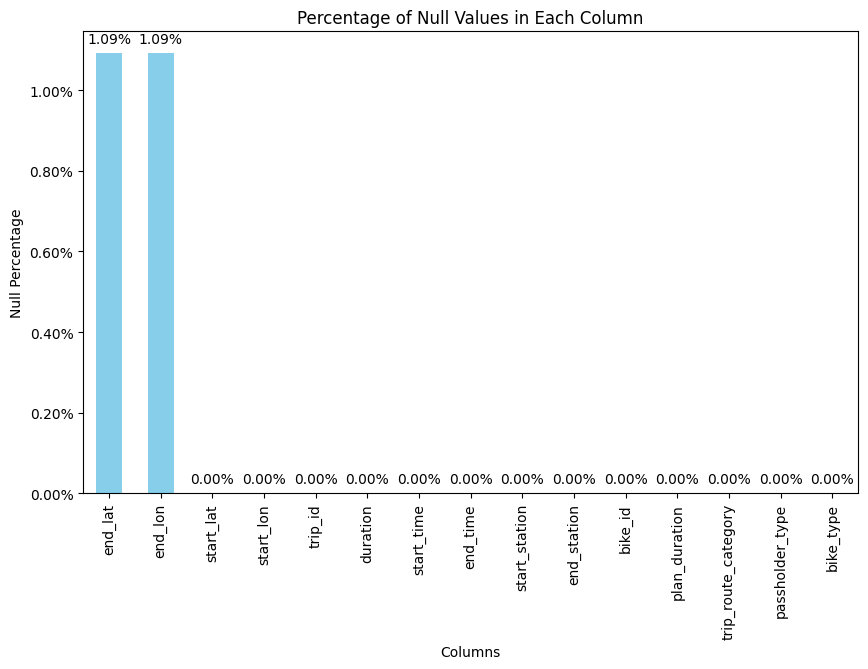

In [197]:
plot_null_values(df)

In [198]:
def null_mode(df):
    df_null = df[df.isnull().any(axis=1)]
    most_common_values = df_null.mode().iloc[0]
    most_common_frequency = df_null.apply(lambda col: col.value_counts().get(most_common_values[col.name], 0))
    mode_percentages = most_common_frequency / len(df_null) * 100
    result_df = pd.DataFrame({'Mode': most_common_values, 'Percentage': mode_percentages})
    return result_df.sort_values(by='Percentage', ascending=False)

In [199]:
null_mode(df)

,Mode,Percentage
end_station,3000,99.974066
trip_route_category,One Way,99.922199
passholder_type,Indego30,67.557054
plan_duration,30.0,67.531120
bike_type,electric,58.013485
duration,5.0,14.393154
start_lat,39.95134,2.074689
start_station,3295,1.970954
start_lon,-75.160271,1.970954
bike_id,19126,0.466805


I am going to remove all start_station and end_station equal to 3000 since that is a virtual station and accounts for all of the null values. This is not important for the analysis.

In [200]:
df_no_virtual = df[(df['end_station'] != '3000') & (df['start_station'] != '3000')]

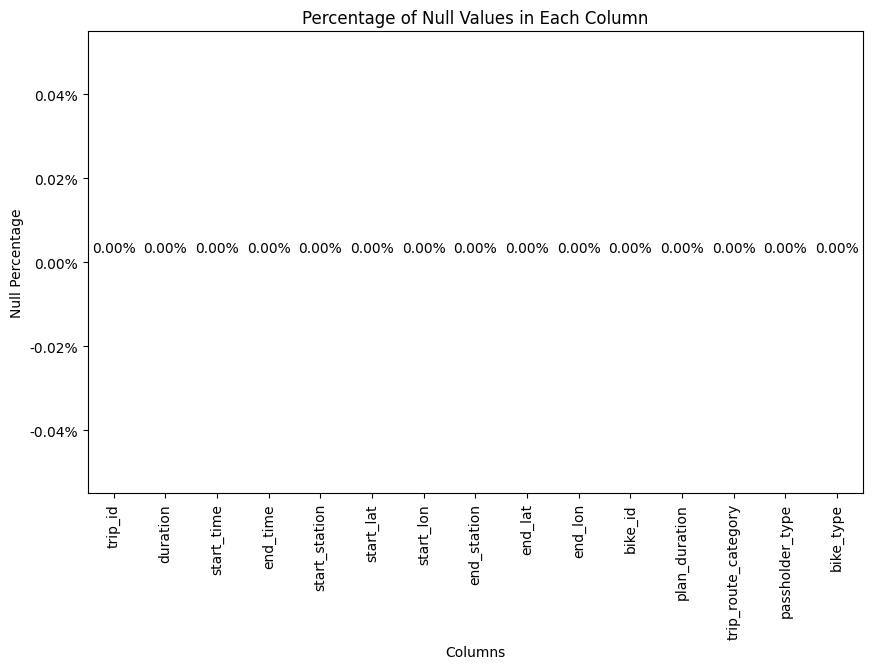

In [201]:
plot_null_values(df_no_virtual)

In [202]:
# check to see if trip_id is unique
df_no_virtual['trip_id'].is_unique

True

Exploring the Data

In [203]:
# merging the station table with the trip table
# add the name of the start and end stations to the trips table
df_no_virtual = df_no_virtual.merge(station_table[['Station_ID', 'Station_Name']], how='left', left_on='start_station', right_on='Station_ID')
df_no_virtual = df_no_virtual.rename(columns={'Station_Name': 'start_station_name'})

df_no_virtual = df_no_virtual.merge(station_table, how='left', left_on='end_station', right_on='Station_ID')
df_no_virtual = df_no_virtual.rename(columns={'Station_Name': 'end_station_name'})

df_no_virtual.drop(columns=['Station_ID_x', 'Station_ID_y'], inplace=True)
df_no_virtual.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,start_station_name,end_station_name,Day of Go_live_date,Status
0,677293140,2,2023-07-01 00:00:00,2023-07-01 00:02:00,3271,39.947601,-75.229462,3246,39.947819,-75.223007,25775,30,One Way,Indego30,electric,53rd & Baltimore,50th & Baltimore,7/27/2021,Active
1,677304406,27,2023-07-01 00:00:00,2023-07-01 00:27:00,3060,39.959229,-75.170357,3255,39.950951,-75.164383,14583,30,One Way,Indego30,standard,Free Library of Philadelphia - Central Library,Broad & Chestnut,9/2/2021,Active
2,677304584,32,2023-07-01 00:00:00,2023-07-01 00:32:00,3057,39.964390,-75.179871,3165,39.958191,-75.178200,5191,1,One Way,Day Pass,standard,Philadelphia Museum of Art,24th & Race SRT,9/27/2017,Active
3,677302282,6,2023-07-01 00:00:00,2023-07-01 00:06:00,3038,39.947811,-75.194092,3256,39.952690,-75.177788,19170,365,One Way,Indego365,electric,The Children's Hospital of Philadelphia (CHOP),23rd & Chestnut,9/21/2021,Active
4,677304444,27,2023-07-01 00:01:00,2023-07-01 00:28:00,3060,39.959229,-75.170357,3255,39.950951,-75.164383,5178,30,One Way,Indego30,standard,Free Library of Philadelphia - Central Library,Broad & Chestnut,9/2/2021,Active


In [204]:
# merge the station table with the trip table to get the latitude and longitude of the stations
station_table_with_coordinates = station_table.merge(
    df_no_virtual[['start_station', 'start_lat', 'start_lon']].drop_duplicates(),
    how='left', 
    left_on='Station_ID', 
    right_on='start_station'
    )

station_table_with_coordinates = station_table_with_coordinates.rename(columns={'start_lat': 'station_lat', 'start_lon': 'station_lon'})

station_table_with_coordinates.drop(columns=['start_station'], inplace=True)

station_table_with_coordinates = station_table.merge(
    df_no_virtual[['end_station', 'end_lat', 'end_lon']].drop_duplicates(),
    how='left', 
    left_on='Station_ID', 
    right_on='end_station'
    )

station_table_with_coordinates = station_table_with_coordinates.rename(columns={'end_lat': 'station_lat', 'end_lon': 'station_lon'})

station_table_with_coordinates.drop(columns=['end_station'], inplace=True)

station_table_with_coordinates

,Station_ID,Station_Name,Day of Go_live_date,Status,station_lat,station_lon
0,3000,Virtual Station,4/23/2015,Active,NaN,NaN
1,3004,Municipal Services Building Plaza,4/23/2015,Inactive,NaN,NaN
2,3005,"Welcome Park, NPS",4/23/2015,Active,39.947330,-75.144028
3,3006,40th & Spruce,4/23/2015,Active,39.952202,-75.203110
4,3007,"11th & Pine, Kahn Park",4/23/2015,Active,39.945171,-75.159927
...,...,...,...,...,...,...
260,3349,25th & Wharton,8/31/2023,Active,39.936508,-75.186211
261,3350,Broad & Lehigh,9/5/2023,Active,39.994148,-75.155273
262,3351,12th & Cambria,9/21/2023,Active,39.996552,-75.149910
263,3353,"Broad & Ontario, Temple Hospital",9/28/2023,Active,40.004959,-75.152328


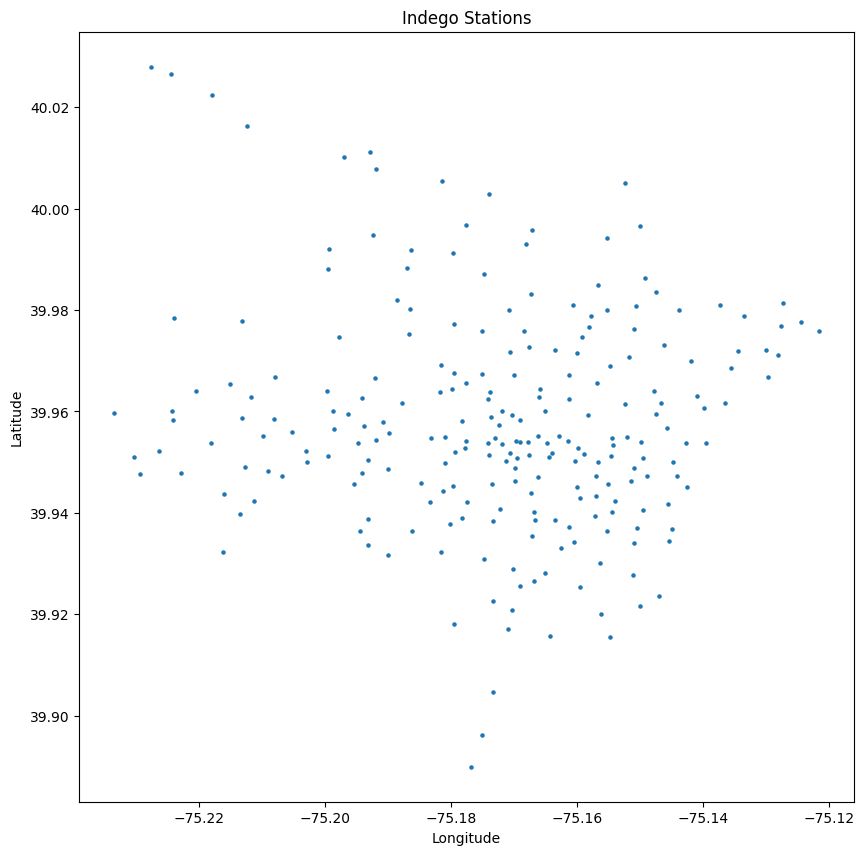

In [205]:
# plot the stations on a maptlotlib basic plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(station_table_with_coordinates['station_lon'], station_table_with_coordinates['station_lat'], s=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Indego Stations')
plt.show()


In [206]:
# plot the unique start station ids by latitude and longitude
# df_no_virtual.groupby(['start_station', 'start_lat', 'start_lon']).size().reset_index().rename(columns={0: 'count'}).plot(kind='scatter', x='start_lon', y='start_lat', figsize=(10, 10), alpha=0.5)

In [207]:
# create a function that takes a station id as an input, and prints a plot showing the origin point and unique end points of all the trips originating from that station

def plot_station(station_id, df):
    station_df = df[df['start_station'] == station_id][['start_station', 'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon']]
    # remove duplicates from station_df
    station_df.drop_duplicates(inplace=True)
    # plot a line from the start location to the end locations
    plt.scatter(station_df['start_lon'], station_df['start_lat'], c='blue', label='Start Location')
    plt.scatter(station_df['end_lon'], station_df['end_lat'], c='red', label='End Location')

    for i in range
    plt.show()

SyntaxError: invalid syntax (165173215.py, line 11)

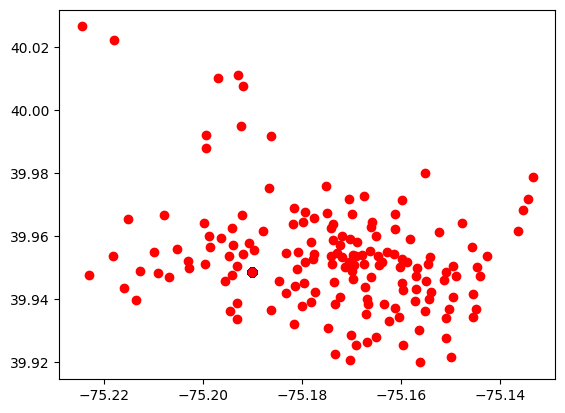

In [208]:
plot_station('3020', df_no_virtual)